In [19]:
from __future__ import annotations

import os
from typing import Literal, Tuple, Dict, Any

from mile.dataset.base import BaseLoader
from mile.config.data import DataConfig, Source, DatasetType, Task

import pandas as pd
import numpy as np
import jax.numpy as jnp
import jax

import matplotlib.pyplot as plt
import seaborn as sns

# Data Generation

In [35]:
GREEN_RGB_COLORS = [
    '#004c00',  # '#004e00', '#005000', '#005100', '#005300',
    # '#005500', # '#005700', '#005900', '#005a00', '#005c00',
    '#005e00',  # '#006000', '#006200', '#006300', '#006500',
    # '#006700', # '#006900', '#006b00', '#006c00', '#006e00',
    '#007000',  # '#007200', '#007400', '#007500', '#007700',
    # '#007900', # '#007b00', '#007d00', '#007e00', '#008000',
    '#008200',  # '#008400', '#008600', '#008800', '#008900',
    # '#008b00', # '#008d00', '#008f00', '#009100', '#009200',
    '#009400',  # '#009600', '#009800', '#009a00', '#009b00',
    # '#009d00', # '#009f00', '#00a100', '#00a300', '#00a400',
    '#00a600',  # '#00a800', '#00aa00', '#00ac00', '#00ad00',
    # '#00af00', # '#00b100', '#00b300', '#00b500', '#00b600',
    '#00b800',  # '#00ba00', '#00bc00', '#00be00', '#00bf00',
    # '#00c100', # '#00c300', '#00c500', '#00c700', '#00c800',
    '#00ca00',  # '#00cc00', '#00ce00', '#00d000', '#00d100',
    # '#00d300', # '#00d500', '#00d700', '#00d900', '#00da00',
    '#00dc00',  # '#00de00', '#00e000', '#00e200', '#00e300',
    # '#00e500', # '#00e700', '#00e900', '#00eb00', '#00ec00',
    '#00ee00',  # '#00f000', '#00f200', '#00f400', '#00f500',
    # '#00f700', # '#00f900', '#00fb00', '#00fd00', '#00ff00'
]


def plot_synthetic_data(
        true_effects: dict,
        response: jnp.ndarray,
):
    """
    Function to plot the synthetic data generated for testing the BayesianNAM model.

    Parameters
    ----------
    true_effects: dict containing the true effects of the features.
    response: jnp.ndarray containing the response variable.
    """

    sns.set_style("whitegrid", {"axes.facecolor": ".9"})

    # Target variable distribution.
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
    sns.distplot(
        response,
        hist=True,
        kde=True,
        bins=30,
        color=GREEN_RGB_COLORS[0],
        label="Target Variable",
        ax=ax
    )
    ax.legend()
    ax.set_title(
        label=f"Distribution of the Target Variable | "
              f"Mean: {response.mean():.2f}, "
              f"Std: {response.std():.2f}",
        fontsize=14
    )
    ax.set_xlabel("Response", fontsize=12)
    ax.set_ylabel("Density", fontsize=12)
    ax.grid(True)
    plt.tight_layout()
    plt.show()

    single_true_effects = {
        feature_name: feature_value for feature_name, feature_value in true_effects.items()
        if ":" not in feature_name
    }
    if single_true_effects:
        fig, axes = plt.subplots(
            nrows=len(single_true_effects),
            ncols=2,
            figsize=(12, 6 * len(single_true_effects))
        )
        for i, feature_name in enumerate(single_true_effects.keys()):
            x_vals = single_true_effects[feature_name]["feature"]
            y_mean = single_true_effects[feature_name]["response"]

            sort_idx = np.argsort(x_vals)
            x_sorted = x_vals[sort_idx]
            y_sorted = y_mean[sort_idx]

            # Plot noise intervals.
            if not isinstance(true_effects[feature_name]["noise_parameters"]["scale"], np.ndarray):
                true_effects[feature_name]["noise_parameters"]["scale"] = (
                        np.ones(len(x_sorted)) * true_effects[feature_name]["noise_parameters"][
                    "scale"]
                )

            for ci_multiplier, alpha in zip([3, 2, 1], [0.2, 0.4, 0.8]):
                axes[i, 0].fill_between(
                    x_sorted,
                    y_sorted - ci_multiplier
                    * true_effects[feature_name]["noise_parameters"]["scale"][sort_idx],
                    y_sorted + ci_multiplier
                    * true_effects[feature_name]["noise_parameters"]["scale"][sort_idx],
                    color=GREEN_RGB_COLORS[-1],
                    alpha=alpha
                )
                # Plot outlines for the filled areas.
                axes[i, 0].plot(
                    x_sorted,
                    y_sorted - ci_multiplier
                    * true_effects[feature_name]["noise_parameters"]["scale"][sort_idx],
                    color='black',
                    linestyle='dashed',
                    alpha=0.2
                )
                axes[i, 0].plot(
                    x_sorted,
                    y_sorted + ci_multiplier
                    * true_effects[feature_name]["noise_parameters"]["scale"][sort_idx],
                    color='black',
                    linestyle='dashed',
                    alpha=0.2
                )

            # Plot points.
            sns.scatterplot(
                x=single_true_effects[feature_name]["feature"][sort_idx],
                y=single_true_effects[feature_name]["response"][sort_idx]
                  + single_true_effects[feature_name]["noise"][sort_idx],
                color=GREEN_RGB_COLORS[5],
                label="Noisy Response",
                ax=axes[i, 0]
            )
            # Plot mean.
            sns.lineplot(
                x=single_true_effects[feature_name]["feature"][sort_idx],
                y=single_true_effects[feature_name]["response"][sort_idx],
                color="black",
                label="True Mean Marginal Effect",
                ax=axes[i, 0],
            )
            axes[i, 0].set_title(f"{feature_name} Effect", fontsize=14)
            axes[i, 0].set_xlabel(f"{feature_name}", fontsize=12)
            axes[i, 0].set_ylabel("Effect", fontsize=12)
            axes[i, 0].legend()
            axes[i, 0].grid(True)

            # Plot noise intervals.
            axes[i, 1].axhline(0, color='black', label="True Noise Mean")
            for ci_multiplier, alpha in zip([3, 2, 1], [0.2, 0.4, 0.8]):
                axes[i, 1].fill_between(
                    x_sorted,
                    -ci_multiplier * true_effects[feature_name]["noise_parameters"]["scale"][
                        sort_idx],
                    ci_multiplier * true_effects[feature_name]["noise_parameters"]["scale"][
                        sort_idx],
                    color=GREEN_RGB_COLORS[-1],
                    alpha=alpha
                )
                # Plot outlines for the filled areas.
                axes[i, 1].plot(
                    x_sorted,
                    -ci_multiplier * true_effects[feature_name]["noise_parameters"]["scale"][
                        sort_idx],
                    color='black',
                    linestyle='dashed',
                    alpha=0.2
                )
                axes[i, 1].plot(
                    x_sorted,
                    ci_multiplier * true_effects[feature_name]["noise_parameters"]["scale"][
                        sort_idx],
                    color='black',
                    linestyle='dashed',
                    alpha=0.2
                )

            # Plot points.
            sns.scatterplot(
                x=single_true_effects[feature_name]["feature"][sort_idx],
                y=single_true_effects[feature_name]["noise"][sort_idx],
                color=GREEN_RGB_COLORS[5],
                label="Sampled Noise",
                ax=axes[i, 1]
            )

            axes[i, 1].set_title(f"{feature_name} Noise Effect", fontsize=14)
            axes[i, 1].set_xlabel(f"{feature_name}", fontsize=12)
            axes[i, 1].set_ylabel("Effect", fontsize=12)
            axes[i, 1].legend()
            axes[i, 1].grid(True)

        plt.legend()
        plt.tight_layout()
        plt.show()


def get_synthetic_data(n_samples: int = 500):
    """
    Function to generate synthetic data for testing the BayesianNAM model.
    Returns a pandas DataFrame containing the synthetic data.

    Args:
        n_samples (int): Number of samples to generate.

    Returns:
        pd.DataFrame: DataFrame containing the synthetic data.
    """

    # ------------------
    # Generate features.
    # ------------------
    np.random.seed(42)

    numerical_1 = np.random.uniform(low=-1, high=1, size=n_samples)
    numerical_2 = np.random.uniform(low=-1, high=1, size=n_samples)
    numerical_3 = np.random.uniform(low=-1, high=1, size=n_samples)
    numerical_4 = np.random.uniform(low=-1, high=1, size=n_samples)

    # categorical_1 = np.random.choice(a=['A', 'B', 'C'], size=n_samples)
    # categorical_2 = np.random.choice(a=['X', 'Y', 'Z'], size=n_samples)
    # encoder = OneHotEncoder()
    # cat_1_encoded = pd.DataFrame(
    #     encoder.fit_transform(categorical_1.reshape(-1, 1)).toarray(),
    #     columns=[f"Cat1_{cat}" for cat in encoder.categories_[0]]
    # )
    # cat_2_encoded = pd.DataFrame(
    #     encoder.fit_transform(categorical_2.reshape(-1, 1)).toarray(),
    #     columns=[f"Cat2_{cat}" for cat in encoder.categories_[0]]
    # )

    # Make the noise parameters dependent on the true effects.
    noise_parameters = {
        "numerical_1": {"loc": 0, "scale": 0.5 + np.square(numerical_1) / 10, "size": n_samples},
        "numerical_2": {"loc": 0, "scale": 0.5 + np.square(numerical_2) / 10, "size": n_samples},
        "numerical_3": {"loc": 0, "scale": 0.5 + np.square(numerical_3) / 10, "size": n_samples},
        "numerical_4": {"loc": 0, "scale": 0.5 + np.square(numerical_4) / 10, "size": n_samples},
        # "numerical_1": {"loc": 0, "scale": 0.1*np.abs(5), "size": n_samples},
        # "numerical_2": {"loc": 0, "scale": 0.1*np.abs(5), "size": n_samples},
        # "numerical_3": {"loc": 0, "scale": 0.1*np.abs(5), "size": n_samples},
        # "numerical_4": {"loc": 0, "scale": 0.1*np.abs(5), "size": n_samples},
        # "categorical_1": {"a": [-1, 0, 1], "p": [0.1, 0.8, 0.1], "size": n_samples},
        # "categorical_2": {"a": [-1, 0, 1], "p": [0.1, 0.8, 0.1], "size": n_samples},
    }

    noise = {
        "numerical_1": np.random.normal(**noise_parameters["numerical_1"]),
        "numerical_2": np.random.normal(**noise_parameters["numerical_2"]),
        "numerical_3": np.random.normal(**noise_parameters["numerical_3"]),
        "numerical_4": np.random.normal(**noise_parameters["numerical_4"]),
        # "categorical_1": np.random.choice(**noise_parameters["categorical_1"]),
        # "categorical_2": np.random.choice(**noise_parameters["categorical_2"])
        # "numerical_1:numerical_2": np.random.normal(**noise_parameters["numerical_1:numerical_2"])
    }

    true_effects = {
        "numerical_1": {
            "response": (numerical_1) ** 2,
            "feature": numerical_1,
            'noise_parameters': noise_parameters["numerical_1"],
            'noise': noise["numerical_1"]
        },
        "numerical_2": {
            "response": np.sin(2 * np.pi * numerical_2),
            "feature": numerical_2,
            'noise_parameters': noise_parameters["numerical_2"],
            'noise': noise["numerical_2"]
        },
        "numerical_3": {
            "response": np.exp(numerical_3 ** 2),
            "feature": numerical_3,
            'noise_parameters': noise_parameters["numerical_3"],
            'noise': noise["numerical_3"]
        },
        "numerical_4": {
            "response": np.zeros_like(numerical_4),
            "feature": numerical_4,
            'noise_parameters': noise_parameters["numerical_4"],
            'noise': noise["numerical_4"]
        },
        # "numerical_1:numerical_2": {
        #     "response": numerical_1 * numerical_2,
        #     "feature": np.stack([numerical_1, numerical_2], axis=-1),
        #     'noise_parameters': noise_parameters["numerical_1:numerical_2"],
        #     'noise': noise["numerical_1:numerical_2"]
        # }
    }

    # noise_parameters = {
    #     "numerical_1": {"loc": 0, "scale": 1, "size": n_samples},
    #     "numerical_2": {"loc": 0, "scale": 1, "size": n_samples},
    #     "numerical_3": {"loc": 0, "scale": 1, "size": n_samples},
    #     "numerical_4": {"loc": 0, "scale": 1, "size": n_samples},
    #     # "categorical_1": {"a": [-1, 0, 1], "p": [0.1, 0.8, 0.1], "size": n_samples},
    #     # "categorical_2": {"a": [-1, 0, 1], "p": [0.1, 0.8, 0.1], "size": n_samples},
    # }
    # noise_parameters["numerical_1:numerical_2"] = {
    #         "loc": (
    #                 noise_parameters["numerical_1"]["loc"] *
    #                 noise_parameters["numerical_2"]["loc"]
    #         ),
    #         "scale": np.sqrt(
    #             (
    #                 noise_parameters["numerical_1"]["loc"]**2 *
    #                 noise_parameters["numerical_2"]["loc"]**2
    #             ) + (
    #                 noise_parameters["numerical_1"]["loc"]**2 *
    #                 noise_parameters["numerical_2"]["scale"]**2
    #             ) + (
    #                 noise_parameters["numerical_2"]["loc"]**2 *
    #                 noise_parameters["numerical_1"]["scale"] ** 2
    #             ) + (
    #                 noise_parameters["numerical_1"]["scale"]**2 *
    #                 noise_parameters["numerical_2"]["scale"]**2
    #             )
    #         ),
    #         "size": n_samples
    #     }
    response = (
            true_effects["numerical_1"]["response"]
            + true_effects["numerical_1"]["noise"] +
            true_effects["numerical_2"]["response"]
            + true_effects["numerical_2"]["noise"]  # +
        # true_effects["numerical_3"]["response"]
        #     + true_effects["numerical_3"]["noise"] +
        # true_effects["numerical_4"]["response"]
        #     + true_effects["numerical_4"]["noise"]  # +
        # true_effects["numerical_1:numerical_2"]["response"]
        #   + true_effects["numerical_1:numerical_2"]["noise"]
    )

    # --------------
    # Plot the data.
    # --------------
    plot_synthetic_data(true_effects=true_effects, response=response)

    # -------
    # Return.
    # -------
    return pd.concat(
        [
            pd.DataFrame(
                data={
                    'numerical_1': numerical_1,
                    'numerical_2': numerical_2,
                    # 'numerical_3': numerical_3,
                    # 'numerical_4': numerical_4,
                }
            ),
            # cat_1_encoded,
            # cat_2_encoded,
            pd.DataFrame(data={'Response': response})
        ], axis=1
    ), true_effects

# Loader

In [36]:
class TabularAdditiveModelDataLoader(BaseLoader):
    """
    A DataLoader that handles dictionary-formatted data of the structure:

    {
        "numerical": {
            "numerical_1": np.ndarray([...]),
            "numerical_2": np.ndarray([...]),
            ...
        },
        "categorical": {
            "categorical_1": np.ndarray([...]),
            "categorical_2": np.ndarray([...]),
            ...
        }
    }

    Optionally, you can include your target/target as a separate key (e.g. "target")
    or embed it as one of the numerical/categorical fields. Below assumes a separate
    "target" key; adjust as needed if you store the target differently.
    """

    def __init__(
        self,
        config: DataConfig,
        rng: jnp.ndarray,
        data_dict: dict,
        target_key: str = "target",
    ):
        """
        Args:
            config (DataConfig): The configuration object containing dataset parameters.
            rng (jnp.ndarray): A PRNGKey for random operations (shuffling, batching).
            data_dict (dict): Dictionary-of-dictionaries containing numerical/categorical
                              features (and optionally the target).
            target_key (str): The key under which the target/target is stored in `data_dict`.
                              If you place the target differently, adjust accordingly.
        """
        super().__init__(config)
        self._key = rng
        self.target_key = target_key

        assert self.config.data_type == DatasetType.TABULAR, (
            "TabularAdditiveModelDataLoader is designed for tabular-style tasks."
        )

        self.data = self._load_data(
            raw_dict=data_dict,
            shuffle=True,
            normalize=self.config.normalize
        )
        if self.config.datapoint_limit:
            self._apply_datapoint_limit()

        N = self._num_datapoints(self.data)
        train_idx = int(N * self.config.train_split)
        valid_idx = int(N * (self.config.train_split + self.config.valid_split))

        self.data_train = self._slice_data(self.data, 0, train_idx)
        self.data_valid = self._slice_data(self.data, train_idx, valid_idx)
        self.data_test  = self._slice_data(self.data, valid_idx, N)

    def __str__(self):
        """Return an informative string representation of the dataloader."""
        num_train = self._num_datapoints(self.data_train)
        num_valid = self._num_datapoints(self.data_valid)
        num_test  = self._num_datapoints(self.data_test)
        return (
            f"{super().__str__()}\n"
            f" | TabularAdditiveModelDataLoader\n"
            f" | Train: {num_train}\n"
            f" | Valid: {num_valid}\n"
            f" | Test:  {num_test}"
        )

    @property
    def key(self) -> jnp.ndarray:
        """Returns a fresh PRNG key and updates the internal key."""
        self._key, new_key = jax.random.split(self._key)
        return new_key

    @property
    def train_x(self):
        """Return the training features (dict of numerical/categorical)."""
        return self._split_features(self.data_train)

    @property
    def train_y(self):
        """Return the training targets."""
        return self._split_targets(self.data_train)

    @property
    def valid_x(self):
        return self._split_features(self.data_valid)

    @property
    def valid_y(self):
        return self._split_targets(self.data_valid)

    @property
    def test_x(self):
        return self._split_features(self.data_test)

    @property
    def test_y(self):
        return self._split_targets(self.data_test)

    def iter(
        self,
        split: Literal["train", "valid", "test"],
        batch_size: int | None = None,
        n_devices: int = 1,
    ):
        """
        Returns a generator that yields batches of the form:
            {
                "feature": {
                    "numerical": { ... },
                    "categorical": { ... }
                },
                "target": jnp.ndarray
            }
        """
        assert split in ("train", "valid", "test"), "split must be train, valid, or test."

        if split == "train":
            data_split = self.data_train
        elif split == "valid":
            data_split = self.data_valid
        else:
            data_split = self.data_test

        yield from self._iter(data_split, batch_size, n_devices)

    def shuffle(self, split: Literal["train", "valid", "test"] = "train"):
        """
        Shuffle the specified split in-place. This applies the same random permutation
        across all numerical/categorical arrays (and target), preserving alignment.
        """
        if split == "train":
            self.data_train = self._shuffle_dict(self.data_train)
        elif split == "valid":
            self.data_valid = self._shuffle_dict(self.data_valid)
        else:
            self.data_test = self._shuffle_dict(self.data_test)

    def __len__(self):
        return self._num_datapoints(self.data)  # Length across all splits.

    def _load_data(self, raw_dict: dict, shuffle: bool, normalize: bool = True):
        """
        Convert raw input dictionary into a unified structure:
          {
             "numerical": { "num_1": jnp.array([...]), ... },
             "categorical": { "cat_1": jnp.array([...]), ... },
             "target": jnp.array([...])     # if present
          }
        Optionally normalizes *only numerical* data. If your target is in numerical,
        you may exclude it from normalization.
        """
        data = {"numerical": {}, "categorical": {}}

        for k, v in raw_dict.get("numerical", {}).items():
            data["numerical"][k] = jnp.array(v)
        for k, v in raw_dict.get("categorical", {}).items():
            data["categorical"][k] = jnp.array(v)
        data["target"] = jnp.array(raw_dict[self.target_key])

        if normalize:
            for num_k, arr in data["numerical"].items():
                # If there's a chance 'arr' is the target, skip it. Adjust logic as needed.
                arr_mean = arr.mean()
                arr_std  = arr.std()
                # Avoid division by zero
                arr_std  = jnp.where(arr_std == 0, 1.0, arr_std)
                data["numerical"][num_k] = (arr - arr_mean) / arr_std

        if shuffle:
            data = self._shuffle_dict(data)

        return data

    def _apply_datapoint_limit(self):
        """
        Clip the entire dictionary to the first N datapoints (as defined in self.config).
        """
        limit = self.config.datapoint_limit
        for subkey in ["numerical", "categorical"]:
            for k, arr in self.data[subkey].items():
                self.data[subkey][k] = arr[:limit]
        if "target" in self.data and self.data["target"] is not None:
            self.data["target"] = self.data["target"][:limit]

    def _num_datapoints(self, data_dict: dict) -> int:
        """
        Return number of samples. We assume that all arrays in 'numerical', 'categorical',
        and 'target' have the same leading dimension. Here we use 'target' if present,
        otherwise we default to the first numerical array.
        """
        if "target" in data_dict and data_dict["target"] is not None:
            return data_dict["target"].shape[0]
        # or fallback to first numerical array
        for _, arr in data_dict["numerical"].items():
            return arr.shape[0]
        # if still nothing, fallback to first categorical
        for _, arr in data_dict["categorical"].items():
            return arr.shape[0]
        return 0

    def _shuffle_dict(self, data_dict: dict) -> dict:
        """Shuffle all arrays in data_dict consistently using the same permutation."""
        n = self._num_datapoints(data_dict)
        if n == 0:
            return data_dict

        indices = jax.random.permutation(self.key, jnp.arange(n))
        # Create a new dictionary with shuffled arrays
        shuffled = {"numerical": {}, "categorical": {}}
        for subkey in ["numerical", "categorical"]:
            for k, arr in data_dict[subkey].items():
                shuffled[subkey][k] = arr[indices]

        if "target" in data_dict and data_dict["target"] is not None:
            shuffled["target"] = data_dict["target"][indices]
        else:
            shuffled["target"] = data_dict.get("target", None)

        return shuffled

    def _slice_data(self, data_dict: dict, start: int, end: int) -> dict:
        """Return a slice of all arrays from start to end along axis 0."""
        sliced = {"numerical": {}, "categorical": {}}
        for subkey in ["numerical", "categorical"]:
            for k, arr in data_dict[subkey].items():
                sliced[subkey][k] = arr[start:end]

        if data_dict.get("target") is not None:
            sliced["target"] = data_dict["target"][start:end]
        else:
            sliced["target"] = None

        return sliced

    def _split_features(self, data_dict: dict) -> dict:
        """
        Return a dict containing only 'numerical' and 'categorical' arrays,
        which can be considered the 'features'.
        """
        return {
            "numerical": data_dict["numerical"],
            "categorical": data_dict["categorical"],
        }

    def _split_targets(self, data_dict: dict) -> jnp.ndarray | None:
        """
        Return the target array as a jnp.ndarray. If classification, cast to int32.
        """
        lbl = data_dict.get("target", None)
        if lbl is None:
            return None
        if self.config.task == Task.CLASSIFICATION:
            return lbl.astype(jnp.int32)
        return lbl

    def _iter(
        self,
        data_dict: dict,
        batch_size: int | None,
        n_devices: int = 1,
    ):
        """
        Generator that yields dictionaries of the form:
            {
                "feature": {
                    "numerical": {...},
                    "categorical": {...}
                },
                "target": jnp.ndarray
            }
        in batches. If `batch_size` is None, return the entire split at once.
        If `n_devices` > 1, replicate the data across devices.
        """
        total = self._num_datapoints(data_dict)
        if total == 0:
            return  # empty generator

        # If no batching, just yield the entire dataset as one batch
        if batch_size is None:
            # Possibly replicate if multiple devices
            if n_devices > 1:
                # replicate each sub-array across device dimension
                batched_data = self._replicate_data_dict(data_dict, n_devices)
                yield self._format_batch(batched_data)
            else:
                yield self._format_batch(data_dict)
            return

        # Otherwise, compute number of batches
        n_batches = total // batch_size
        # Truncate leftover
        truncated_end = n_batches * batch_size

        # We'll create a random permutation of indices, then split them
        indices = jax.random.permutation(self.key, jnp.arange(total))
        indices = indices[:truncated_end]  # drop leftover
        # Split the indices into n_batches
        indices_split = jnp.array_split(indices, n_batches)

        for i in range(n_batches):
            # For multi-device, we replicate each batch across devices with separate permutations
            if n_devices > 1:
                # We want a separate random permutation for each device
                device_indices = [
                    jax.random.permutation(self.key, jnp.arange(total))[:batch_size]
                    for _ in range(n_devices)
                ]
                # Stack into shape (n_devices, batch_size)
                device_indices = jnp.stack(device_indices, axis=0)
                # Gather from data
                batched_data = self._gather_indices(data_dict, device_indices)
            else:
                # Single device
                batched_data = self._gather_indices(data_dict, indices_split[i])

            yield self._format_batch(batched_data)

    def _gather_indices(self, data_dict: dict, indices: jnp.ndarray) -> dict:
        """
        Gather sub-arrays from data_dict at the given indices. If indices has shape
        (n_devices, batch_size), we gather a device dimension as well.
        """
        # Indices shape can be (batch_size,) or (n_devices, batch_size)
        gathered = {"numerical": {}, "categorical": {}}

        for subkey in ["numerical", "categorical"]:
            gathered[subkey] = {
                k: arr[indices] for k, arr in data_dict[subkey].items()
            }

        if data_dict["target"] is not None:
            gathered["target"] = data_dict["target"][indices]
        else:
            gathered["target"] = None

        return gathered

    def _format_batch(self, data_dict: dict) -> dict:
        """
        Convert data_dict into the final batch format:
            {
                "feature": {
                    "numerical": {...},
                    "categorical": {...}
                },
                "target": jnp.ndarray
            }
        """
        # The target might need int32 cast if classification
        target = data_dict["target"]
        if target is not None and self.config.task == Task.CLASSIFICATION:
            target = target.astype(jnp.int32)

        return {
            "feature": {
                "numerical": data_dict["numerical"],
                "categorical": data_dict["categorical"],
            },
            "target": target,
        }

    def _replicate_data_dict(self, data_dict: dict, n_devices: int) -> dict:
        """
        Replicate each array in data_dict along a new axis(0), such that shape becomes
        (n_devices, ...).
        """
        replicated = {"numerical": {}, "categorical": {}}
        for subkey in ["numerical", "categorical"]:
            for k, arr in data_dict[subkey].items():
                replicated[subkey][k] = jnp.repeat(arr[None, ...], n_devices, axis=0)

        if data_dict["target"] is not None:
            replicated["target"] = jnp.repeat(data_dict["target"][None, ...], n_devices, axis=0)
        else:
            replicated["target"] = None

        return replicated


C:\Users\Aleks Lyubenov\AppData\Local\Temp\ipykernel_23796\3004213867.py:42: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(


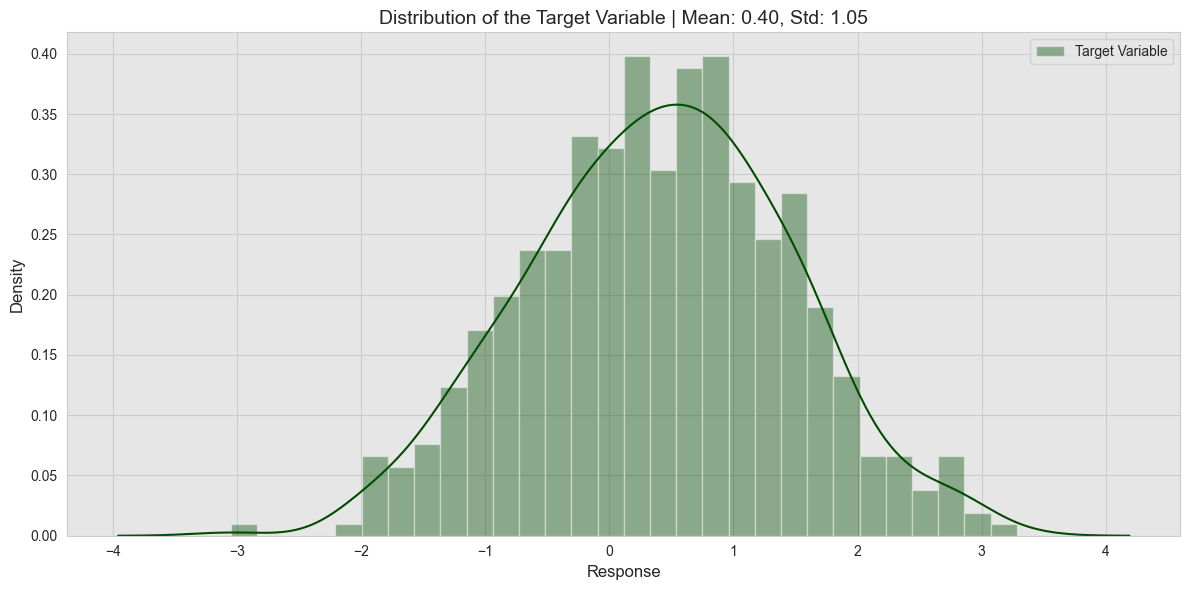

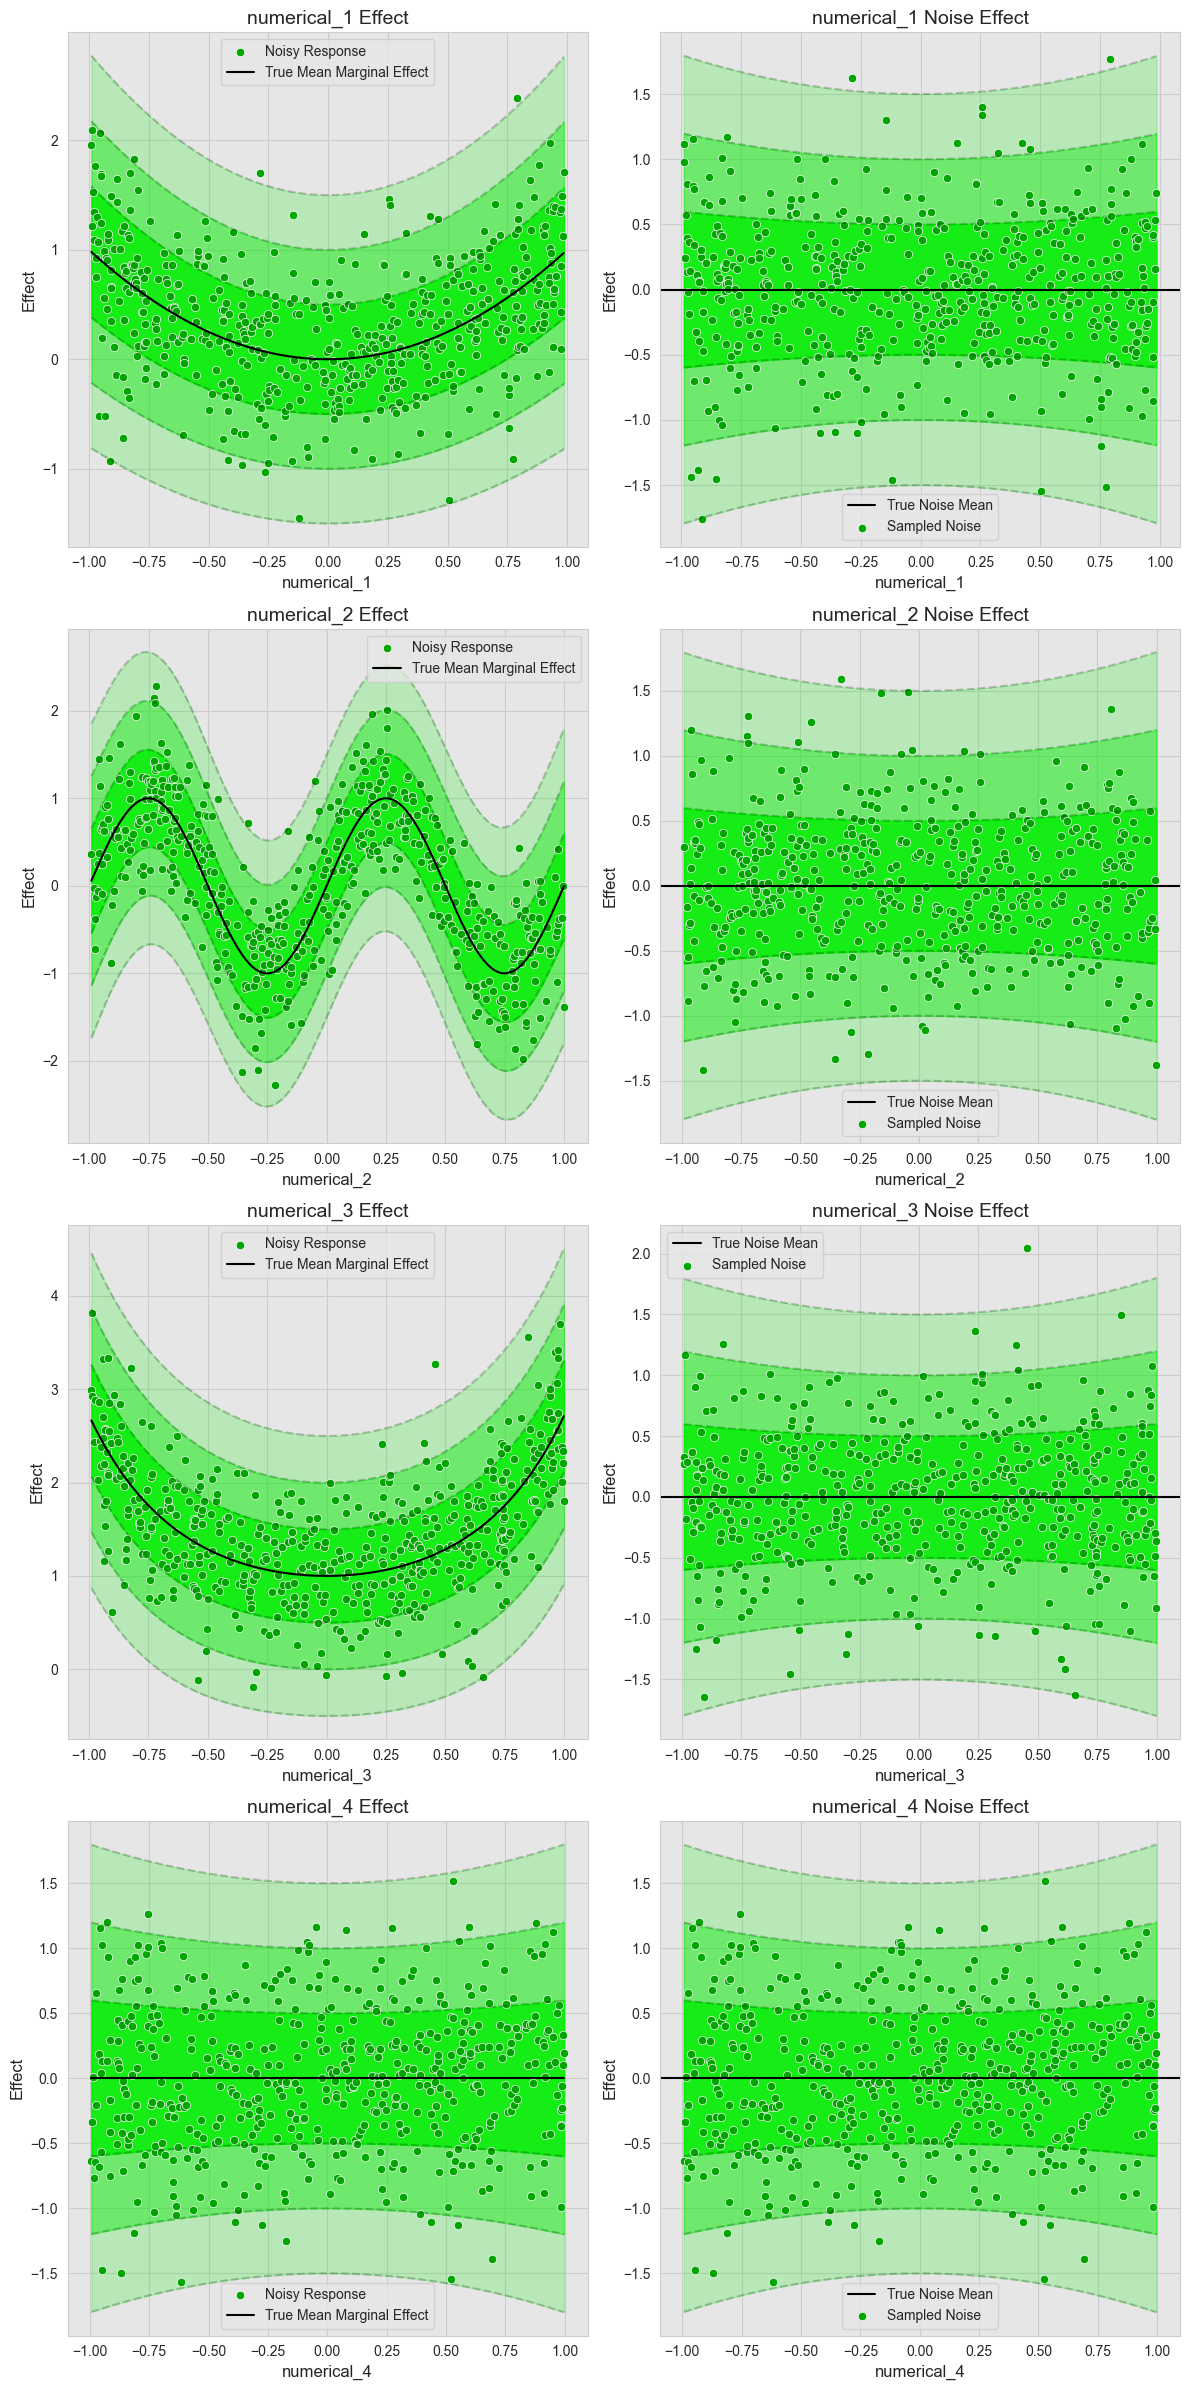

TabularAdditiveModelDataLoader:
 | Data: synthetic
 | Task: regr
 | TabularAdditiveModelDataLoader
 | Train: 350
 | Valid: 99
 | Test:  51


In [37]:
# Make sure you have the TabularAdditiveModelDataLoader class from the earlier example
# e.g., from your_project.dataloader import TabularAdditiveModelDataLoader

# 1) Generate synthetic data
df, true_effects = get_synthetic_data(n_samples=500)

# 2) Convert your DataFrame to a dictionary of arrays
#    Here, we treat "numerical_1" and "numerical_2" as numerical features
#    and "Response" as the target.
data_dict = {
    "numerical": {
        "numerical_1": df["numerical_1"].values,
        "numerical_2": df["numerical_2"].values,
    },
    "categorical": {},  # none here, but if you had categorical features, put them here
    "target": df["Response"].values,  # or rename key to something else if you like
}

# 3) Create a DataConfig
#    The path/source fields are less critical for in-memory synthetic data,
#    but need valid placeholders. (E.g., 'path' can be "synthetic" if you like.)
config = DataConfig(
    path="synthetic",      # a dummy path for synthetic data
    source=Source.LOCAL,
    data_type=DatasetType.TABULAR,
    task=Task.REGRESSION,  # or CLASSIFICATION if your response is discrete
    target_column="Response",  # or None if not using column-based logic
    target_len=1,
    datapoint_limit=None,  # optionally limit how many samples to load
    normalize=True,        # apply normalization to numerical data
    train_split=0.7,
    valid_split=0.2,
    test_split=0.1,
)

# 4) Instantiate the loader with a JAX PRNG key
rng = jax.random.PRNGKey(42)
loader = TabularAdditiveModelDataLoader(config, rng, data_dict)

# 5) Example usage:
#    - Print info about the loader
print(loader)

In [38]:
train_features = loader.train_x
train_targets = loader.train_y

In [39]:
for batch in loader.iter(split="train", batch_size=64):
    # Each batch is a dict: {"feature": {...}, "target": ...}
    features = batch["feature"]  # "numerical" & "categorical" sub-dicts
    targets   = batch["target"]

    num_1 = features["numerical"]["numerical_1"]
    num_2 = features["numerical"]["numerical_2"]
    print(f"num_1 batch shape: {num_1.shape}, targets shape: {targets.shape}")
    break  # just one batch for demo

num_1 batch shape: (64,), targets shape: (64,)
